
IOTA Nonlinear lattice: .../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx 


These distributions were constructed using 'synergia.optics.generated_matched_bunch_transverse' method:



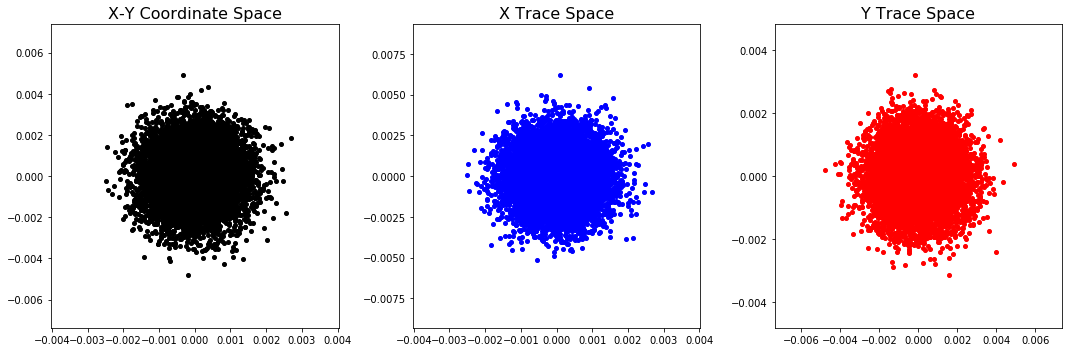

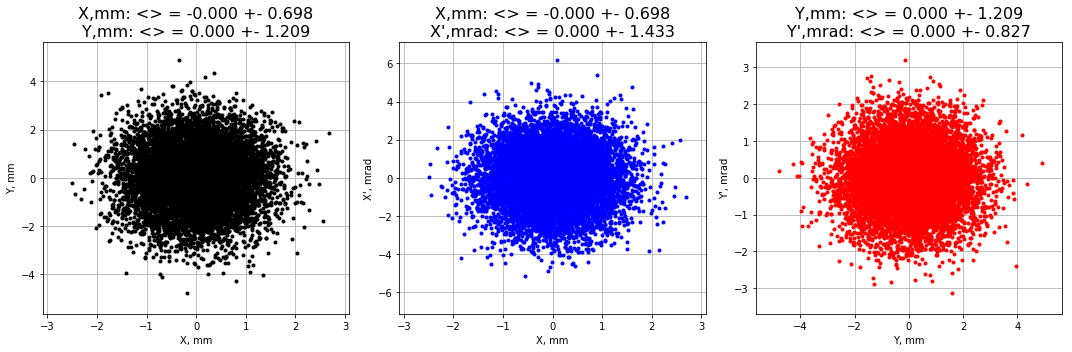

In [2]:
# 
# This script uses parts of scripts 'turn_aend_action_lattice_edit.py' (Chris) 
# and 'variabledNLsimulation_v0.py' (Yury)
#
#    Started at June 13, 2019
#
import synergia
import os, sys
import inspect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import rssynergia 
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import plotbeam
from rssynergia.base_diagnostics import pltbunch

def plotcoordDistr(bunchParticles):
#    
# Plot X-X', Y-Y', and X-Y distributions for 'bunchParticles'
#
    shapePartcls = bunchParticles.shape
    numbPartcls = shapePartcls[0]
    shapePartcls[0]
    particles = bunchParticles.real
    newCoordinates = np.zeros((6,numbPartcls))
    for k in range(numbPartcls):
        for j in range(6):
            newCoordinates[j,k] = 1.e3*particles[k,j]       # Units: mm and mrad 
    xmax = 1.15*np.max(newCoordinates[0,:])
    xpmax = 1.15*np.max(newCoordinates[1,:])
    ymax = 1.15*np.max(newCoordinates[2,:])
    ypmax = 1.15*np.max(newCoordinates[3,:])
    meanX = np.mean(newCoordinates[0,:])
    meanPX = np.mean(newCoordinates[1,:])
    stdX = np.std(newCoordinates[0,:])
    stdPX = np.std(newCoordinates[1,:])
    meanY = np.mean(newCoordinates[2,:])
    meanPY = np.mean(newCoordinates[3,:])
    stdY = np.std(newCoordinates[2,:])
    stdPY = np.std(newCoordinates[3,:])

    #another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(newCoordinates[0,:],newCoordinates[2,:],'.',color='k')
    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
    ax0.set_title(x0Title,fontsize='16')
    ax0.set_xlim([-xmax,xmax])
    ax0.set_ylim([-ymax,ymax])
    ax0.set_xlabel('X, mm')
    ax0.set_ylabel('Y, mm')
    ax0.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(newCoordinates[0,:],newCoordinates[1,:],'.',color='b')
    x1Title = "X,mm: <> = {:.3f} +- {:.3f}\nX\',mrad: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanPX,stdPX)
    ax1.set_title(x1Title,fontsize='16')
    ax1.set_xlim([-xmax,xmax])
    ax1.set_ylim([-xpmax,xpmax])
    ax1.set_xlabel('X, mm')
    ax1.set_ylabel('X\', mrad')
    ax1.grid(True)
    
    ax2 = plt.subplot(gs[2])
    plt.plot(newCoordinates[2,:],newCoordinates[3,:],'.',color='r')
    x2Title = "Y,mm: <> = {:.3f} +- {:.3f}\nY\',mrad: <> = {:.3f} +- {:.3f}".format(meanY,stdY,meanPY,stdPY)
    ax2.set_title(x2Title,fontsize='16')
    ax2.set_xlim([-ymax,ymax])
    ax2.set_ylim([-ypmax,ypmax])
    ax2.set_xlabel('Y, mm')
    ax2.set_ylabel('Y\', mrad')
    ax2.grid(True)
    
#    fig.canvas.set_window_title('Synergia Phase Space Distribution')
    fig.tight_layout()
    plt.show()
    return

def printAttributes(object,name,title):
#
# List of all attributes of 'object' for checking:
#
    attrList = inspect.getmembers(object)
    strTitle = "\nattrList ("+name+" = "+title+"):\n{}\n"
    print strTitle.format(attrList)

# Pickle helper is not necessary but is retained for this example
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state
        
# Derived class to ramp quadrupoles

# Will be passed into propagator and called at each appropriate 'interval' (step, turn, action, etc...)

class Ramp_actions(synergia.simulation.Propagate_actions, Pickle_helper):
# The arguments to __init__ are what the Ramp_actions instance is initialized with
    def __init__(self, multiplier1,multiplier2, outputFlag):
        selfObject = synergia.simulation.Propagate_actions.__init__(self)
# To recognize attributes of 'selfObject':
#        printAttributes(selfObject,'selfObject','synergia.simulation.Propagate_actions.__init__(self)')

# Pickling the arguments to the initializer allows the module to resume
# after checkpointing. They should be in the same order as the arguments to __init__.
        Pickle_helper.__init__(self, multiplier1, multiplier2, outputFlag)
        self.multiplier1 = multiplier1
        self.multiplier2 = multiplier2
        self.outputFlag = outputFlag
    def turn_end_action(self, stepper, bunch, turn_num):
#---------------------------
# For checking:
#        testObject = stepper.get_lattice_simulator().get_lattice()
# To recognize attributes of 'testObject':
#        printAttributes(testObject,'testObject','stepper.get_lattice_simulator().get_lattice()')
#        print "testName = '{}'".format(testObject.get_name())
#---------------------------
# Output title for checking of variables update:   
        if self.outputFlag == 1:
            print "Modifying lattice:"
        for element in stepper.get_lattice_simulator().get_lattice().get_elements():
            if element.get_type() == "nllens":
                old_knll = element.get_double_attribute("knll")
                element.set_double_attribute("knll", self.multiplier1*old_knll)
                old_cnll = element.get_double_attribute("cnll")
                element.set_double_attribute("cnll", self.multiplier2*old_cnll)
# Output for hecking of variables update:  
                if ((self.outputFlag == 1) and (element.get_name() == "n.11")):
                    print element.get_name(),":  knll=",old_knll,"-->", \
                       self.multiplier1*old_knll, ";  cnll=",old_cnll,"-->",self.multiplier2*old_cnll
        stepper.get_lattice_simulator().update()
    
# Routine Simulation Setup

# Lattice:
fileIOTA = ".../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx"
print "\nIOTA Nonlinear lattice: {} \n".format(fileIOTA)
lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
"../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx")
#----------------------------------
# To recognize attributes of 'lattice':
# printAttributes(lattice,'lattice','synergia.lattice.MadX_reader().get_lattice')

# madxAttributes = synergia.lattice.MadX_reader()
# To recognize attributes of 'doubleAttributes':
# printAttributes(madxAttributes,'madxAttributes','synergia.lattice.MadX_reader()')

# doubleVariable = madxAttributes.get_double_variable()
# To recognize attributes of 'doubleVariable':
# printAttributes(doubleVariable,'doubleVariable','madxAttributes.get_double_variablte()')
# print "doubleVariable = ", doubleVariable
#---------------------------------
'''
# For checking only:
k = 0
for elem in lattice.get_elements():
    if k == 0:
        printAttributes(elem,'elem','lattice.get_elements')
    k += 1
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
    else:
        elem.set_string_attribute("extractor_type", "chef_map")
    print "elem ({}): name = {}, type = {}, stringAttrbt ={}". \
          format(k,elem.get_name(),elem.get_type(),elem.get_string_attribute("extractor_type"))
'''    

# Original version:
# attice_simulator = synergia.simulation.Lattice_simulator(lattice, 2)
# Bunch:
# bunch = synergia.optics.generate_matched_bunch_transverse(lattice_simulator, 1e-6, \
#                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)

# YuE version:
stepperCrrnt = synergia.simulation.Independent_stepper_elements(lattice,2,3)
lattice_simulator_Crrnt = stepperCrrnt.get_lattice_simulator()
# Bunch:
bunch_origin = synergia.optics.generate_matched_bunch_transverse(lattice_simulator_Crrnt, 1e-6, \
                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)
#-------------------------------------------------
# For checking only:
#
# 1) Attributes:
# printAttributes(bunch,'bunch','synergia.optics.generate_matched_bunch_transverse')
# 2) Distributions X-Y, X-X', Y-Y' using method 'pltbunch.plot_bunch':
loclTitle = "\nThese distributions were constructed using \
'synergia.optics.generated_matched_bunch_transverse' method:\n"
print loclTitle
pltbunch.plot_bunch(bunch_origin)     
# 3) Distributions X-Y, X-X', Y-Y' using method 'plotcoordDistr':
bunchParticles = bunch_origin.get_local_particles()
# To recognize attributes of 'bunchParticles':
# printAttributes(bunchParticles,'bunchParticles', 'bunch.get_local_particles()')
plotcoordDistr(bunchParticles)
#--------------------------------------------------



-------------------

           Nonlinear parameters are not changed

-------------------

Turn   1 is completed (CPU time =  4.840 seconds)
Turn   2 is completed (CPU time =  4.750 seconds)

              After 2 turns:



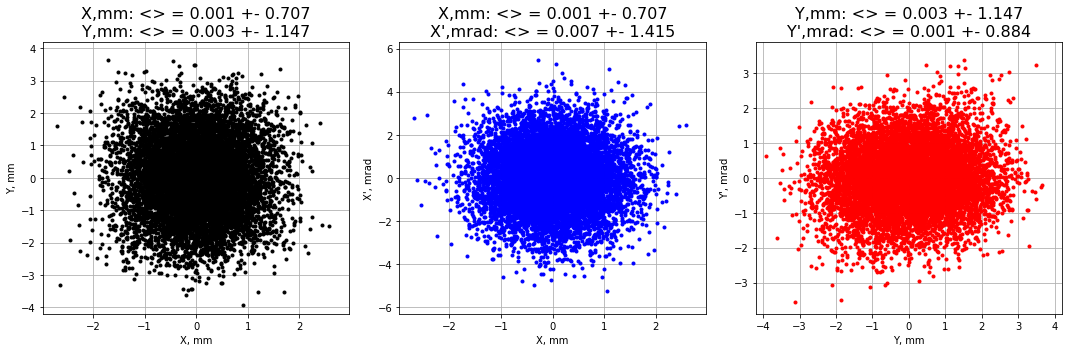


Plotting is completed (CPU time =  0.930 seconds)

Turn   3 is completed (CPU time =  4.780 seconds)
Turn   4 is completed (CPU time =  4.720 seconds)

              After 4 turns:



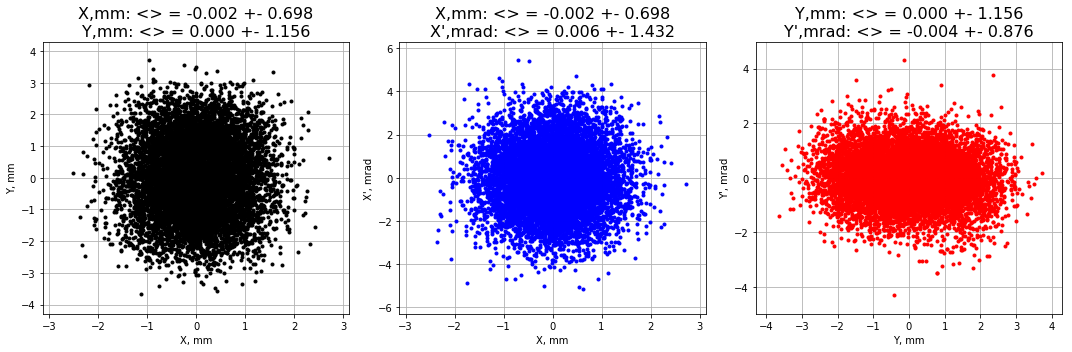


Plotting is completed (CPU time =  0.930 seconds)

Turn   5 is completed (CPU time =  4.710 seconds)
Turn   6 is completed (CPU time =  4.720 seconds)

              After 6 turns:



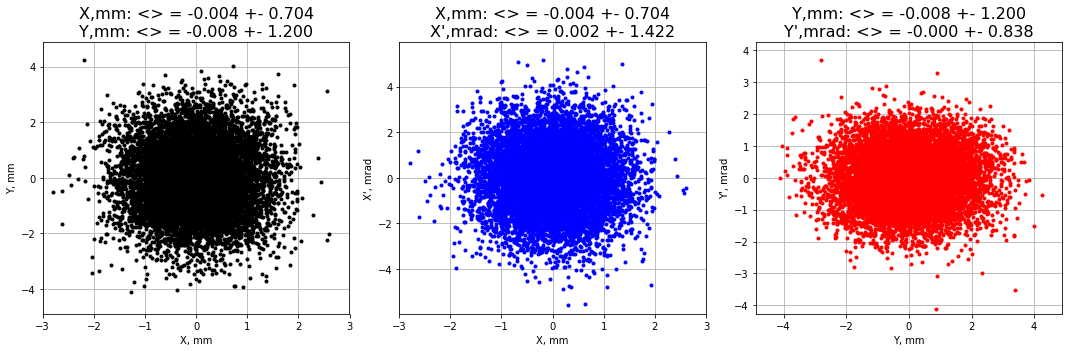


Plotting is completed (CPU time =  0.810 seconds)

Turn   7 is completed (CPU time =  4.740 seconds)
Turn   8 is completed (CPU time =  4.830 seconds)

              After 8 turns:



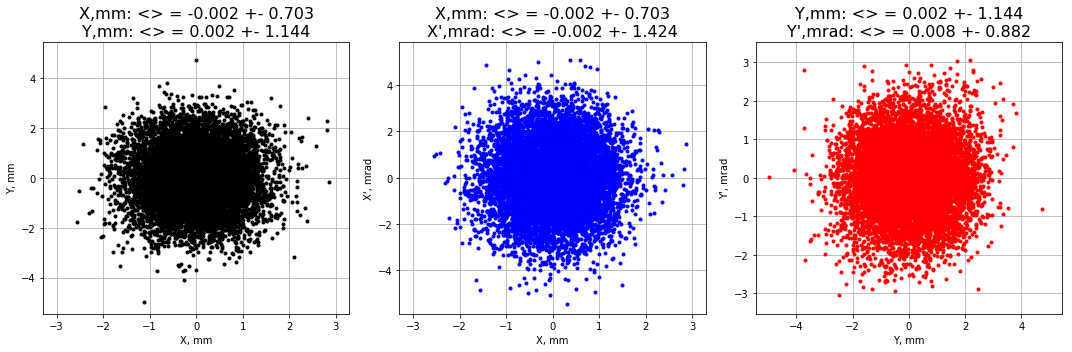


Plotting is completed (CPU time =  0.820 seconds)

Turn   9 is completed (CPU time =  4.710 seconds)
Turn  10 is completed (CPU time =  4.700 seconds)

              After 10 turns:



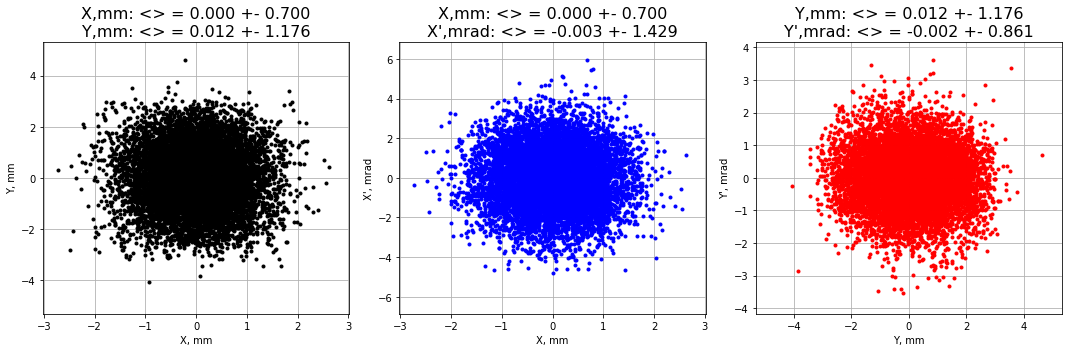


Plotting is completed (CPU time =  0.870 seconds)


For    10 turns CPU time = 51.860 seconds


-------------------

           Nonlinear parameters will be CHANGED with values = 5% after each 2 turns

-------------------

Turn   1 is completed (CPU time =  4.730 seconds)
Turn   2 is completed (CPU time =  4.710 seconds)

              After 2 turns:



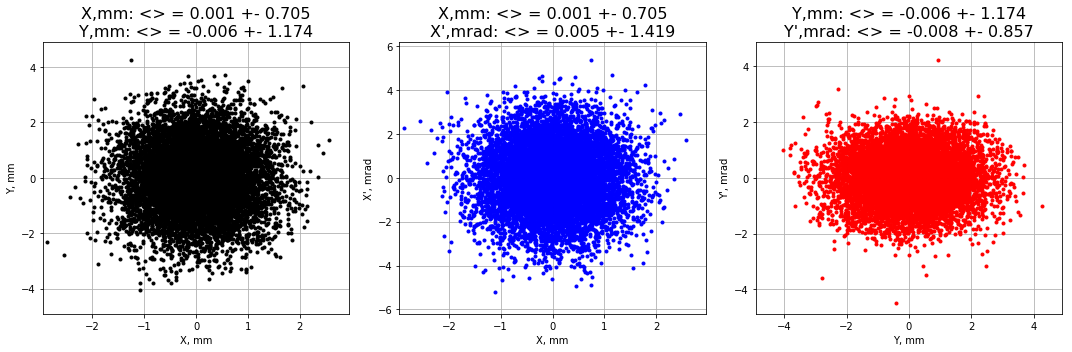

Modifying lattice:
n.11 :  knll= 5.479576037e-06 --> 5.75355483885e-06 ;  cnll= 0.008105461952 --> 0.0077001888544

Update and plotting are completed (CPU time =  5.760 seconds)

Turn   3 is completed (CPU time =  4.810 seconds)
Turn   4 is completed (CPU time =  4.840 seconds)

              After 4 turns:



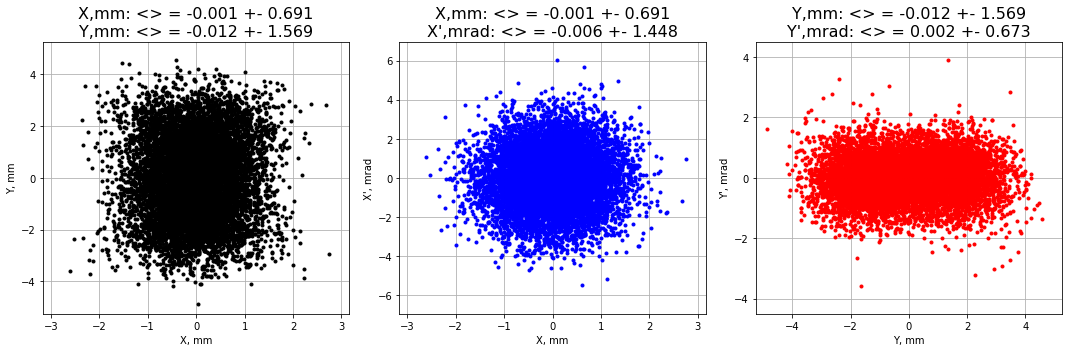

Modifying lattice:
n.11 :  knll= 5.75355483885e-06 --> 6.04123258079e-06 ;  cnll= 0.0077001888544 --> 0.00731517941168

Update and plotting are completed (CPU time =  5.740 seconds)

Turn   5 is completed (CPU time =  4.860 seconds)
Turn   6 is completed (CPU time =  4.710 seconds)

              After 6 turns:



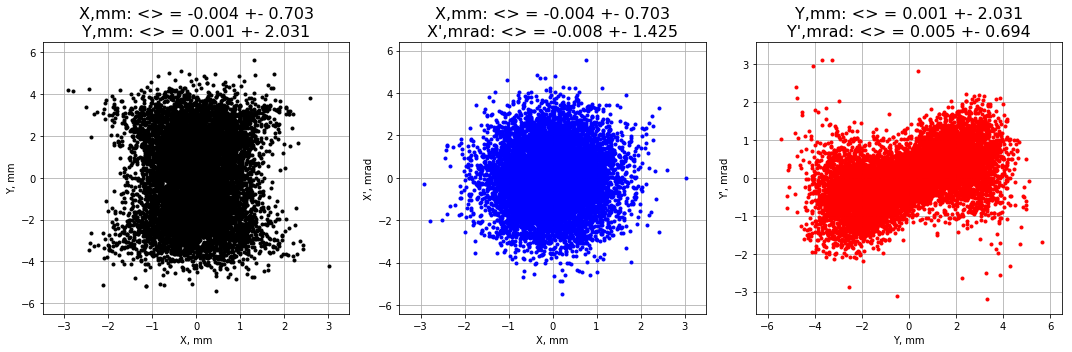

Modifying lattice:
n.11 :  knll= 6.04123258079e-06 --> 6.34329420983e-06 ;  cnll= 0.00731517941168 --> 0.0069494204411

Update and plotting are completed (CPU time =  5.920 seconds)

Turn   7 is completed (CPU time =  4.740 seconds)
Turn   8 is completed (CPU time =  4.700 seconds)

              After 8 turns:



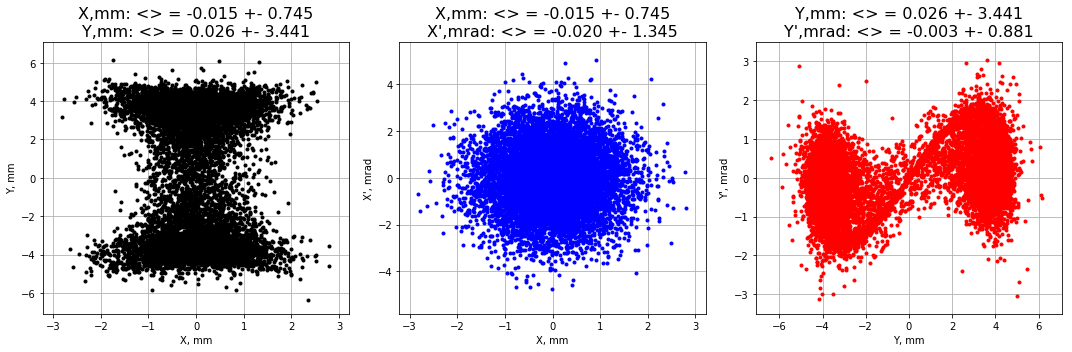

Modifying lattice:
n.11 :  knll= 6.34329420983e-06 --> 6.66045892032e-06 ;  cnll= 0.0069494204411 --> 0.00660194941904

Update and plotting are completed (CPU time =  5.790 seconds)

Turn   9 is completed (CPU time =  4.730 seconds)
Turn  10 is completed (CPU time =  4.690 seconds)

              After 10 turns:



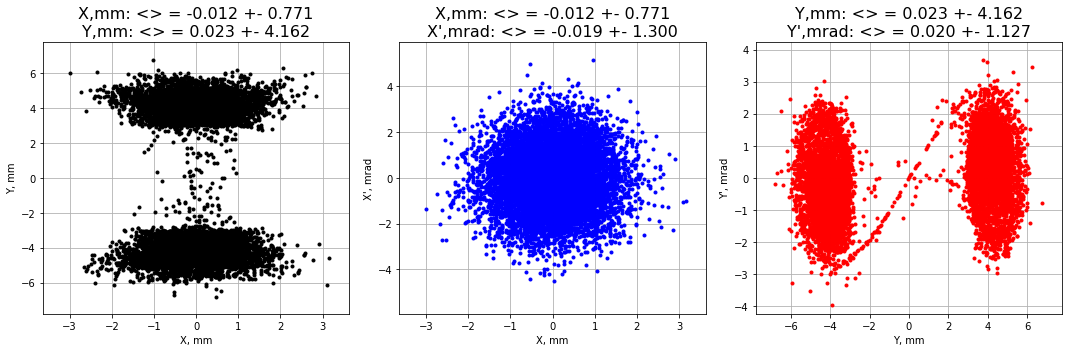

Modifying lattice:
n.11 :  knll= 6.66045892032e-06 --> 6.99348186634e-06 ;  cnll= 0.00660194941904 --> 0.00627185194809

Update and plotting are completed (CPU time =  5.820 seconds)


For    10 turns CPU time = 76.550 seconds



In [3]:
# Steppers (YuE: both case 'splitoperator' and 'independent' work properly!):
# stepper = 'splitoperator'
stepper = 'independent'
if stepper == "splitoperator":
    # Use the Split operator stepper with a dummy collective operator
    # (with evenly-spaced steps)
    no_op = synergia.simulation.Dummy_collective_operator("stub")
    stepper = synergia.simulation.Split_operator_stepper(
                            lattice_simulator_Crrnt, no_op, 4)
elif stepper == "independent":
    # Use the Independent particle stepper (by element)
    stepper = synergia.simulation.Independent_stepper_elements(
                            lattice_simulator_Crrnt, 4)
else:
    sys.stderr.write("fodo.py: stepper must be either 'independent' or 'splitoperator'\n")
    sys.exit(1)


# Bunch simulator:
bunch_simulator = synergia.simulation.Bunch_simulator(bunch_origin)

'''
# Diagnostics:
diagnostic_flag = 'None'
for part in range(0, 0):
    bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("step_track_%02d.h5" % part,
                                                                   part))
if diagnostic_flag == 'step_full2':
    bunch_simulator.add_per_step(synergia.bunch.Diagnostics_full2("step_full2.h5"))
if diagnostic_flag == 'step_particles':
    bunch_simulator.add_per_step(synergia.bunch.Diagnostics_particles("step_particles.h5"))
for part in range(0, 0):
    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_track("turn_track_%02d.h5" % part,
                                                                   part))
if diagnostic_flag == 'turn_full2':
    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_full2("turn_full2.h5"))
if diagnostic_flag == 'turn_particles':
    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_particles("turn_particles.h5"))
'''    

totalTurns = 10

#---------------------------
# Propagate
#---------------------------
# Ramp action is instantiated and passed to the propagator instance during the propagate method

        
plotAfterEachTurn = 2

print "\n-------------------\n"
print "           Nonlinear parameters are not changed"
print "\n-------------------\n"

bunch = bunch_origin
bunch_simulator = synergia.simulation.Bunch_simulator(bunch)

propagator = synergia.simulation.Propagator(stepper)
# propagator.set_checkpoint_period(0)
# propagator.set_checkpoint_with_xml(True)

nUpdate = 0
totalTimeCPU = 0.
for turnCrrnt in range(totalTurns):
    timeStart = os.times()
    propagatorCrrnt = propagator.propagate(bunch_simulator, 1, 1, 0)
# To recognize attributes of 'propagatorCrrnt':
#    printAttributes(propagatorCrrnt,'propagatorCrrnt', \
#                    'propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)')
    turnNumber = turnCrrnt+1
    timeEnd = os.times()
    timeOfTurn = float(timeEnd[0] - timeStart[0])              # CPU time in seconds
    totalTimeCPU += timeOfTurn
    print ('Turn %3d is completed (CPU time = %6.3f seconds)' % (turnNumber, timeOfTurn))
    nUpdate += 1
    if nUpdate == plotAfterEachTurn:
        nUpdate = 0
        print "\n              After {} turns:\n".format(turnNumber)
        timeStart = os.times()
        bunchParticles = bunch.get_local_particles()
        plotcoordDistr(bunchParticles)
        timeEnd = os.times()
        timeOfPlot = float(timeEnd[0] - timeStart[0])              # CPU time in seconds
        totalTimeCPU += timeOfPlot
        print ('\nPlotting is completed (CPU time = %6.3f seconds)\n' % timeOfPlot)
print ('\nFor %5d turns CPU time = %6.3f seconds\n' % (totalTurns, totalTimeCPU))
        
updateAfterEachTurn = 2

print "\n-------------------\n"
print "           Nonlinear parameters will be CHANGED with values = 5% after each {} turns". \
format(updateAfterEachTurn)
print "\n-------------------\n"
bunch = bunch_origin
bunch_simulator = synergia.simulation.Bunch_simulator(bunch)

propagator = synergia.simulation.Propagator(stepper)
# propagator.set_checkpoint_period(0)
# propagator.set_checkpoint_with_xml(True)

nUpdate = 0
totalTimeCPU = 0.
for turnCrrnt in range(totalTurns):
    timeStart = os.times()
    propagatorCrrnt = propagator.propagate(bunch_simulator, 1, 1, 0)
# To recognize attributes of 'propagatorCrrnt':
#    printAttributes(propagatorCrrnt,'propagatorCrrnt', \
#                    'propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)')
    turnNumber = turnCrrnt+1
    timeEnd = os.times()
    timeOfTurn = float(timeEnd[0] - timeStart[0])              # CPU time in seconds
    totalTimeCPU += timeOfTurn
    print ('Turn %3d is completed (CPU time = %6.3f seconds)' % (turnNumber, timeOfTurn))
    nUpdate += 1
    if nUpdate == updateAfterEachTurn:
        nUpdate = 0
        print "\n              After {} turns:\n".format(turnNumber)
        timeStart = os.times()
        bunchParticles = bunch.get_local_particles()
        plotcoordDistr(bunchParticles)
        ramp_actions = Ramp_actions(1.05,.95,1)   
        propagatorCrrnt = propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)
        timeEnd = os.times()
        timeUpdateAndPlot = float(timeEnd[0] - timeStart[0])              # CPU time in seconds
        totalTimeCPU += timeUpdateAndPlot
        print ('\nUpdate and plotting are completed (CPU time = %6.3f seconds)\n' % timeUpdateAndPlot)
print ('\nFor %5d turns CPU time = %6.3f seconds\n' % (totalTurns, totalTimeCPU))
